In [2]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.autonotebook import tqdm
from gpzoo.kernels import RBF
from gpzoo.gp import VNNGP, SVGP
from gpzoo.likelihoods import GaussianLikelihood

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
N = 10000
X = distributions.Uniform(-5, 5).sample((N, ))
y = 2*torch.sin(2*X) + distributions.Normal(0.0, 0.1).sample((N,))

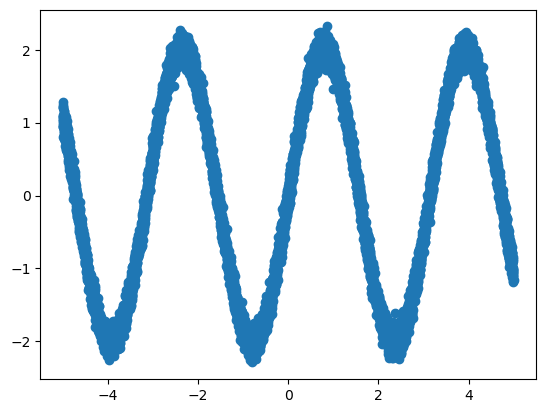

In [5]:
plt.scatter(X, y)

In [6]:
M = 500
kernel = RBF(sigma=1.0, lengthscale=5.0)
gp = SVGP(kernel, dim=1, M=M, jitter=1e-3)
gp.Z = nn.Parameter(10.0*torch.rand((M, 1))-5.0) #choose inducing points
model = GaussianLikelihood(gp)

In [7]:
model.to(device)

GaussianLikelihood(
  (gp): SVGP(
    (kernel): RBF()
  )
)

In [8]:
X_train = (X[:, None]).to(device)
y_train = y.to(device)

In [9]:
def fit(model, X, y, optimizer, epochs=1000, E=20):
    losses = []
    for it in tqdm(range(epochs)):
        optimizer.zero_grad()
        pY, qF, qU, pU = model.forward(X, E=E)
        ELBO = (pY.log_prob(y)).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qU, pU))
        loss = -ELBO
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    print("finished Training")
    return losses

In [11]:
optimizer = optim.Adam(params= model.parameters(), lr=1e-3)

In [12]:
losses = fit(model, X_train, y_train, optimizer, epochs=100, E=20)

  0%|          | 0/100 [00:00<?, ?it/s]

finished Training


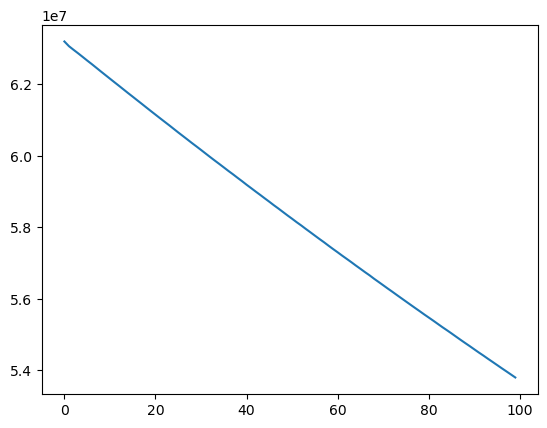

In [13]:
plt.plot(losses)

In [14]:
X_test = torch.linspace(-12, 12, 1000)

In [15]:
qF, _, _ = model.gp(X_test[:, None].to(device), verbose=True)
mean_test = qF.mean.detach().cpu()

calculating Kxx
calculating Kzx
calculating kzz
calculating cholesky
calculating W


In [16]:
mean_test.shape

torch.Size([1000])

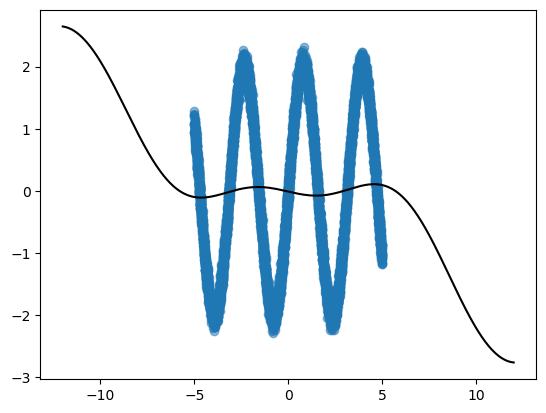

In [17]:
plt.plot(X_test, mean_test, color='black')
plt.scatter(X, y, alpha=0.5)

In [ ]:
model.gp.kernel.lengthscale = nn.Parameter(torch.tensor(5.0))

In [ ]:
model.gp.kernel.sigma

In [ ]:
model.noise

In [18]:
torch.isnan(model.gp.mu).sum()

tensor(0, device='cuda:0')